In [153]:
from collections import defaultdict
import warnings
from sys import stderr

from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import stock_indicators as sa
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import pandas as pd
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
import yfinance as yf
from stock_indicators import Quote
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
warnings.filterwarnings("ignore")

In [47]:
funds_w_names = defaultdict(pd.DataFrame)

In [48]:
etf_names = ['IE0005042456', 'EDMU.SW', 'EDG2.L', '36BA.DE', 'CBUS.DE', 'EWSA.AS','IE00B0M62X26','IE00B14X4Q57','IE00B1XNHC34','IE00B3FH7618','IE00B3ZW0K18','IE00B52MJY50','IE00B52VJ196','IE00B5M4WH52','IE00B66F4759','IE00B9M6RS56','IE00BD8PGZ49','IE00BDFK1573','IE00BDZVH966','IE00BFNM3G45','IE00BGPP6697','IE00BHZPJ015','IE00BHZPJ452','IE00BHZPJ783',
'IE00BLDGH553','IE00BMDFDY08','IE00BMG6Z448','IE00BYYHSM20','IE00BYZTVT56','IE00BZ173V67','IE00BZ1NCS44']

In [49]:
print(etf_names)

['IE0005042456', 'EDMU.SW', 'EDG2.L', '36BA.DE', 'CBUS.DE', 'EWSA.AS', 'IE00B0M62X26', 'IE00B14X4Q57', 'IE00B1XNHC34', 'IE00B3FH7618', 'IE00B3ZW0K18', 'IE00B52MJY50', 'IE00B52VJ196', 'IE00B5M4WH52', 'IE00B66F4759', 'IE00B9M6RS56', 'IE00BD8PGZ49', 'IE00BDFK1573', 'IE00BDZVH966', 'IE00BFNM3G45', 'IE00BGPP6697', 'IE00BHZPJ015', 'IE00BHZPJ452', 'IE00BHZPJ783', 'IE00BLDGH553', 'IE00BMDFDY08', 'IE00BMG6Z448', 'IE00BYYHSM20', 'IE00BYZTVT56', 'IE00BZ173V67', 'IE00BZ1NCS44']


In [85]:
for fund in etf_names:
    a = (pd.DataFrame(yf.Ticker(fund).history(start="2023-01-01", end="2024-01-01")))
    a.index = pd.to_datetime(a.index)
    a.index = a.index.normalize()
    full_date_range = pd.date_range(start=a.index.min(), end=a.index.max(), freq="D")
    a = a.reindex(full_date_range)
    a.fillna(method="bfill", inplace=True)
    a.drop(["Dividends", "Stock Splits", "Capital Gains"], inplace=True, axis=1)
    funds_w_names[fund] = a

Could not get exchangeTimezoneName for ticker '' reason: 'chart'
$: possibly delisted; no timezone found


ValueError: Neither `start` nor `end` can be NaT

In [8]:
def portfolio_factory(etfs: list):
    giga_fund = pd.DataFrame()
    c = 0
    for f in etfs:
        f.index = pd.to_datetime(f.index)  # ensure index is datetime if not already
        f["time_idx"] = (f.index.date - f.index.date[0]).astype("timedelta64[D]").astype(int)
        f['group_id'] = c
        
        giga_fund = pd.concat([giga_fund, f])
        c+= 1
    return giga_fund

In [9]:
def technical_indicators_factory(etfs: list, names: list):
    indicators_per_fund = defaultdict(pd.DataFrame)
    figs = []

    for id, f in enumerate(etfs):

        quotes_for_f = [
            Quote(
                date=row.Index,
                open=row.Open,
                high=row.High,
                low=row.Low,
                close=row.Close,
                volume=row.Volume
            )
            for row in IE.itertuples()]

        ema_for_f = sa.indicators.get_ema(quotes_for_f, 9)
        valid_ema_for_f = [
            (result.date, result.ema)
            for result in ema_for_f
            if result.ema is not None
        ]
        ema_dates, ema_values = zip(*valid_ema_for_f)

        vwma_for_f = sa.indicators.get_vwma(quotes=quotes_for_f, lookback_periods=20)
        valid_vwma_for_f = [
            (result.date, result.vwma)
            for result in vwma_for_f
            if result.vwma is not None
        ]
        vwma_dates, vwma_values = zip(*valid_vwma_for_f)

        macd_for_f = sa.indicators.get_macd(quotes=quotes_for_f)
        valid_macd_for_f = [
            (result.date, result.macd, result.signal, result.histogram)
            for result in macd_for_f
            if result.macd is not None and result.signal is not None and result.histogram is not None
        ]
        macd_dates, macd_values, macd_signal, macd_histogram = zip(*valid_macd_for_f)

        stoch_for_f = sa.indicators.get_stoch(quotes=quotes_for_f)
        valid_stoch_for_f = [
            (result.date, result.oscillator, result.signal, result.percent_j)
            for result in stoch_for_f
            if result.date is not None and result.oscillator is not None and result.signal is not None
        ]
        stoch_dates, stoch_oscillator, stoch_signal, stoch_percent_j  = zip(*valid_stoch_for_f)

        fig, axes = plt.subplots(4, 1, figsize=(12,6))
        axes[0].plot(ema_dates[-20:], ema_values[-20:], label='EMA', linewidth=2)
        axes[0].plot(ema_dates[-20:], f['Close'][-20:], label='Close', linewidth=2)
        axes[0].legend(loc='best')

        axes[1].plot(vwma_dates[-20:], vwma_values[-20:], label='VWMA', linewidth=2)
        axes[1].plot(vwma_dates[-20:], f['Close'][-20:], label='Close', linewidth=2)
        axes[1].legend(loc='best')

        axes[2].plot(macd_dates[-20:], macd_values[-20:], label='MACD', linewidth=2)
        axes[2].plot(macd_dates[-20:], macd_signal[-20:], label='Signal', linewidth=2)
        axes[2].legend(loc='best')

        axes[3].plot(stoch_dates[-20:], stoch_oscillator[-20:], label='STOCH OSCILLATOR', linewidth=2)
        axes[3].plot(stoch_dates[-20:], stoch_percent_j[-20:], label='%J', linewidth=2)
        axes[3].plot(stoch_dates[-20:], stoch_signal[-20:], label='Signal', linewidth=2)
        axes[3].legend(loc='best')

        f['EMA'] = [x.ema for x in ema_for_f]
        f['MACD'] = [x.macd for x in macd_for_f]
        f['VWMA'] = [x.vwma for x in vwma_for_f]
        f['STOCH_OSCILLATOR'] = [x.oscillator for x in stoch_for_f]
        figs.append(fig)

        indicators_per_fund[names[id]]= f
    return indicators_per_fund, figs

In [10]:
def fit_predict(training_cutoff_idx: pd.Timestamp, epochs: int, batch_size: int, lr: float, dropout: float, df: pd.DataFrame, independent_variables: list):
    training = TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff_idx],  # Use the determined cutoff index
        time_idx="time_idx",                             # Sequential time index
        target="Close",                                  # Target variable
        group_ids=["group_id"],                          # Group identifier
        min_encoder_length=365 // 2,      # Minimum input sequence length
        max_encoder_length=365,           # Maximum input sequence length
        min_prediction_length=1,                         # Minimum forecast length
        max_prediction_length=7,     # Maximum forecast length (31 for December)
        static_reals=[],                                 # No static real variables
        time_varying_known_reals= independent_variables,  # Known inputs
        time_varying_unknown_reals=["Close"],            # Target variable
        target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
        add_relative_time_idx=True,                      # Add relative time index
        add_target_scales=True,                               # Scale the target variable
        add_encoder_length=True,                          # Include encoder length feature
        allow_missing_timesteps=False,                   # Ensure no missing steps
    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        df,
        predict=True,
        stop_randomization=True                             # Ensures no randomization in validation dataset
    )

    batch_size = batch_size

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=lr,              # Learning rate
        hidden_size=16,                  # Model hidden size
        attention_head_size=1,           # Number of attention heads
        dropout=dropout,                     # Dropout rate
        hidden_continuous_size=8,        # Hidden size for continuous variables
        output_size=7,                   # Output quantiles (e.g., 10th to 90th percentile)
        loss=QuantileLoss(),             # Loss function
        log_interval=10,                 # Log every 10 batches
        reduce_on_plateau_patience=4,    # Reduce learning rate on plateau
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints/",
        filename="tft-model-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        monitor="val_loss",  # 
        mode="min",  # minimize validation loss
    )

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=4, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

    trainer = pl.Trainer(
        # logger=logger,
        max_epochs=epochs,
        accelerator='cuda',
        devices="auto",
        gradient_clip_val=0.1,
        callbacks=[early_stop_callback, lr_logger, checkpoint_callback],
    )

    trainer.fit(tft, train_dataloader, val_dataloader)
    raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)
    predicted_median_np = raw_predictions.output.prediction[0, :, 1].detach().cpu().numpy()
    return predicted_median_np

In [11]:
def metrics_and_plt(df: pd.DataFrame, preds:list, date_range:pd.date_range):
    actual_values = df["Close"]["2023-12-23":]
    mse = mean_squared_error(actual_values, preds)

    plt.figure(figsize=(10, 6))
    plt.plot(date_range, actual_values, marker="x", label="Actual Close", color="orange")
    plt.plot(date_range, preds, marker="o", label="Predicted Median")
    plt.title("Predicted Values for December 23 to December 29, 2023")
    plt.xlabel("Date")
    plt.ylabel("Predicted Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    return mse, plt

NO INDICATORS, ONE ETF

In [12]:
#IE00B52MJY50
IE = portfolio_factory(etfs=[funds_w_names['IE00B52MJY50']])

In [13]:
training_cutoff_date = pd.to_datetime("2023-12-22 00:00:00+01:00").tz_convert("Europe/London")
training_cutoff_idx = IE.loc[training_cutoff_date, "time_idx"]

In [316]:
IE_preds = fit_predict(training_cutoff_idx=training_cutoff_idx, epochs=12, batch_size=128, lr=1e-3, dropout=0.1, df=IE, independent_variables=["Open", "High", "Low", "Volume"])

[INFO] pytorch_lightning.utilities.rank_zero 2024-11-28 22:50:27,528 _info:63 - GPU available: True (cuda), used: True
[INFO] pytorch_lightning.utilities.rank_zero 2024-11-28 22:50:27,529 _info:63 - TPU available: False, using: 0 TPU cores
[INFO] pytorch_lightning.utilities.rank_zero 2024-11-28 22:50:27,529 _info:63 - HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 144    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.7 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.0 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm |

[DEBUG] fsspec.local 2024-11-28 22:50:27,583 __init__:351 - open file: C:/Users/valky/DataspellProjects/HF_Thesis/lightning_logs/version_29/hparams.yaml
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s, v_num=29, train_loss_step=6.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, v_num=29, train_loss_step=5.230, val_loss=6.850, train_loss_epoch=6.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  4.21it/s, v_num=29, train_loss_step=4.990, val_loss=6.060, train_loss_epoch=5.650]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 2/2 [00:00<00:00,  4.14it/s, v_num=29, train_loss_step=4.700, val_loss=5.480, train_loss_epoch=4.760]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s, v_num=29, train_loss_step=4.250, val_loss=5.120, train_loss_epoch=4.620]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|███

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DEBUG] fsspec.local 2024-11-28 22:50:42,927 __init__:351 - open file: C:/Users/valky/DataspellProjects/HF_Thesis/lightning_logs/version_30/hparams.yaml


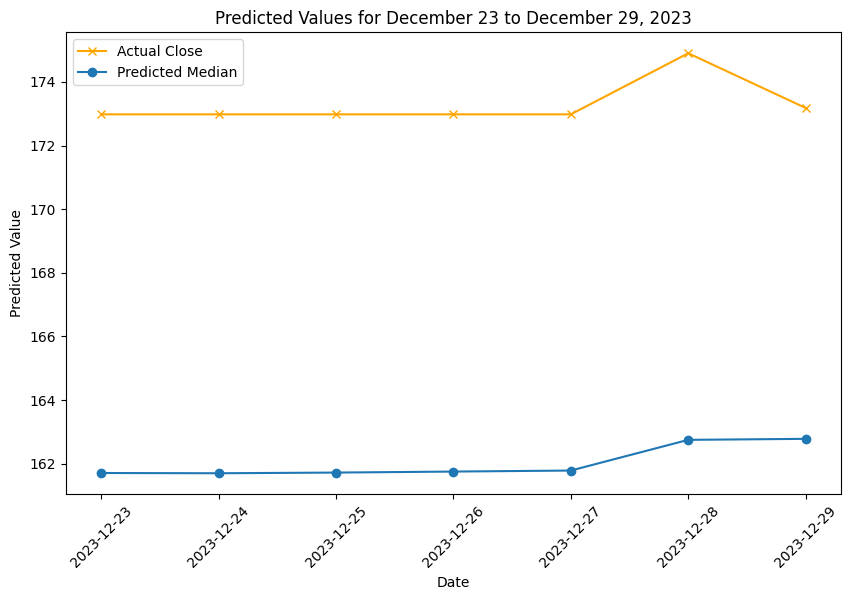

In [318]:
IE_mse, IE_plt = metrics_and_plt(IE, IE_preds, pd.date_range(start="2023-12-23", end="2023-12-29"))

ADDING INDICATORS

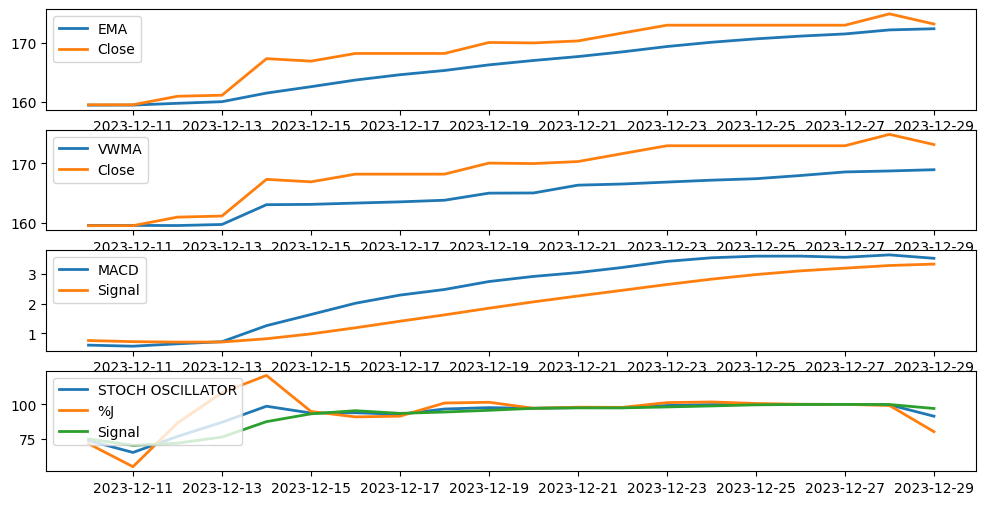

In [302]:
IE_indicators, IE_indicators_plt1 = technical_indicators_factory([funds_w_names['IE00B52MJY50']], ['IE00B52MJY50'])

In [ ]:
IE_preds = fit_predict(training_cutoff_idx=training_cutoff_idx, epochs=120, batch_size=128, lr=1e-4, dropout=0.1, df=IE, independent_variables=["Open", "High", "Low", "Volume", "EMA", "VWMA", "MACD", "STOCH_OSCILLATOR"])

In [ ]:
IE_indicators_mse, IE_indicators_plt2= metrics_and_plt(IE_preds, pd.date_range(start="2023-12-23", end="2023-12-29"))

FULL HEDGE PORTFOLIO

In [ ]:
IE_indicators, IE_indicators_plt1 = technical_indicators_factory([funds_w_names['IE00B52MJY50']], ['IE00B52MJY50'])

In [ ]:
GIGAFUND, GIGAFUND_MIN_IND = portfolio_factory(etfs=funds_w_names.values())

In [175]:
def volatility_dataset_factory(funds):
    log_returns = defaultdict(pd.DataFrame)
    for k, v in funds.items():
        print(f"{k}:")
        funds[k]["Return"] = funds[k]["Close"].pct_change()
        log_returns[k] = np.log(1+funds[k]["Return"])
        log_returns[k].fillna(value=0, inplace=True)
        funds[k]["Rolling Volatility"] = funds[k]["Return"].rolling(7).std()
        funds[k].fillna(method="bfill", inplace=True)

In [176]:
volatility_dataset_factory(funds_w_names)

IE0005042456:
EDMU.SW:
EDG2.L:
36BA.DE:
CBUS.DE:
EWSA.AS:
IE00B0M62X26:
IE00B14X4Q57:
IE00B1XNHC34:
IE00B3FH7618:
IE00B3ZW0K18:
IE00B52MJY50:
IE00B52VJ196:
IE00B5M4WH52:
IE00B66F4759:
IE00B9M6RS56:
IE00BD8PGZ49:
IE00BDFK1573:
IE00BDZVH966:
IE00BFNM3G45:


Monte Carlo

In [178]:
def calc_drift(funds):
    drift_dict={}
    for k, v in funds.items():
        avg_pdr = funds[k].mean()
        var = funds[k].var()
        drift = avg_pdr-(.5*var)
        drift_dict[k]=drift
    return drift_dict

In [179]:
def monte_carlo_sim(funds):
    price_paths={}
    for k, v in funds.items():
        stdev=log_returns[k].std()
        days=362
        trials=100
        Z = norm.ppf(np.random.rand(days,trials))
        daily_returns=np.exp(np.array(drifts[k]) + np.array(stdev) * Z)
        price_paths[k] = np.zeros_like(daily_returns)
        price_paths[k][0] = funds[k]["Close"].iloc[-1]
        for i in range(1,days):
            price_paths[k][i] = price_paths[k][i-1] * daily_returns[i-1]
    return price_paths

In [180]:
pp=monte_carlo_sim(funds_w_names)

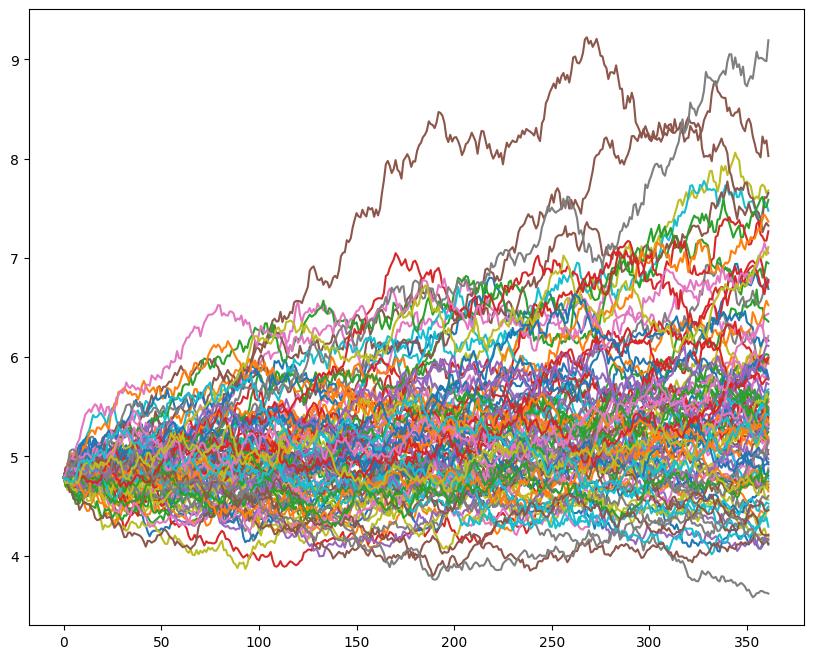

In [181]:
plt.figure(figsize=(10, 8))
plt.plot(pp["EWSA.AS"])